 # Solving a linear elasticity problem on a GeoModel
 
Linear elasticity is the simplest mechanical problem you can solve on a domain.
In this notebook, we show how to solve it with the support of RINGMesh and its GeoModel using the [Firedrake finite element python library](https://www.firedrakeproject.org).

As an example, we will run a problem with a single well inside an homogeneous material. By applying some boundary conditions, we will try to reproduce the analytical solutions ok Kirsh. Theses solution show the stress distribution around the well.

![Problem definitions](images/problem2.png)
<center><i>[Mazuyer Ph.D Thesis, 2018]</i></center>

First, we import the usefuls stuffs

In [1]:
import gompy            #Make the link between Graphite/RINGMesh and Python
from firedrake import * #The Finite Element Library
import numpy as np      # A popular library with useful numerical tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

We create a SceneGraph object. This is the that will contains some Graphite objects (grob). The GeoModel will be one Grob

In [2]:
scene_graph = gom.create(classname='OGF::SceneGraph',interpreter=gom)
scene_graph.clear()

## Geometry creation

We load the GeoModel

In [3]:
gm = scene_graph.create_object('GeoModel3d','gm3d'); # Creation of an empty Geomodel
gm.load('new2.gm'); #Loading of the GeoModel

We get **without a copy** the tables containing the vertices and the cell connectivities

In [4]:
#Get the vertices
vertices = np.asarray(gm.get_geomodel_mesh_vertices()) 
#Get the cell connectivities
cell_connectivities = np.asarray(gm.get_geomodel_mesh_cell_connectivities())

We create the mesh within the Firedrake data structure

In [5]:
# Creation of a mesh data structure
dm = mesh._from_cell_list(3, cell_connectivities, vertices, COMM_WORLD)
# Next five lines are for retrieving the boundary faces
dm.createLabel(dmplex.FACE_SETS_LABEL)
dm.markBoundaryFaces("boundary_faces")
coords = dm.getCoordinates()
coord_sec = dm.getCoordinateSection()
boundary_faces = dm.getStratumIS("boundary_faces", 1).getIndices()


We flag the boundary faces with indexes
 1. West face
 2. East face
 3. South Face
 4. North Face
 5. Bottom Face
 6. Top Face

In [6]:
for face in boundary_faces:
    face_coords = dm.vecGetClosure(coord_sec, coords, face)
    if face_coords[0] < -2.4 and face_coords[3] < -2.4 and face_coords[6] < -2.4:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 1)
    if face_coords[0] > 2.4 and face_coords[3] > 2.4 and face_coords[6] > 2.4:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 2)
    if face_coords[1] < -2.4 and face_coords[4] < -2.4 and face_coords[7] < -2.4:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 3)
    if face_coords[1] > 2.4 and face_coords[4] > 2.4 and face_coords[7] > 2.4:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 4)
    if face_coords[2] < -4.9 and face_coords[5] < -4.9 and face_coords[8] < -4.9:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 5)
    if face_coords[2] > -0.1 and face_coords[5] > -0.1 and face_coords[8] > -0.1:
        dm.setLabelValue(dmplex.FACE_SETS_LABEL, face, 6)

Then we create the Firedrake mesh object using the mesh data structure

In [7]:
mesh = Mesh(dm)

## Problem definition

We give some info on the model geometry

In [8]:
aa = 0.1 # Radius of the well

We define the boundary conditions

In [9]:
# Classical Function Space that will hold the 3D displacement solution
V = VectorFunctionSpace(mesh, "CG", 2)
# Dirichlet boundary conditions
bc_top = DirichletBC(V.sub(2), Constant(0), 6) #Z displacement blocked on Top face
bc_north = DirichletBC(V.sub(1), Constant(0), 4)  #Y displacement blocked on North
bc_east = DirichletBC(V.sub(0), Constant(0), 2)   #X displacement blocked on East

We define the elasticity Lame coefficients

In [10]:
mu = Constant(1.894E9)
lambda_ = Constant(3.367E9)

We define the Neumann boundary conditions SV, SHMax, Shmin
 - SV on Top face
 - SHMax on West face
 - Shmin on South face

In [11]:
SHMax = 20000
Shmin = 10000
Sv = 5000
shmax = as_vector([SHMax, 0, 0])
shmin = as_vector([0, Shmin, 0])
sv = as_vector([0, 0, Sv])

Then we define the kinematic equation linking the displacement to the strain and the constitutive equation linking the strain to the stress (Hooke's law)

In [12]:
Id = Identity(mesh.geometric_dimension()) # 2x2 Identity tensor
def epsilon(u): #Kinematic equation
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):  #Hooke's law
    return lambda_*div(u)*Id + 2*mu*epsilon(u)

## Setting the finite element problem in firedrake

In [13]:
# Trial function
u = TrialFunction(V)
# Test function
v = TestFunction(V)
#Weak form of the elasticity problem
a = inner(sigma(u), epsilon(v))*dx
L = dot(sv, v)*ds(5) + dot(shmax, v)*ds(1) + dot(shmin, v)*ds(3)
# Creation of uh which will contain the solution
uh = Function(V, name="Displacement")

## Finite Element resolution

In [14]:
solve(a == L, uh, bcs=[bc_top, bc_north, bc_east], solver_parameters={"ksp_monitor": True})

## Postprocess : Stress computation

In [15]:
# Discontinous finite element space
VV = TensorFunctionSpace(mesh, "DG", 2);
# Creation of the stress function
stress_function = Function(VV, name="Stress");
# Interpolation on the mesh
stress_function.interpolate(sigma(uh));

## Saving the results

We output the results in a file readable by paraview

In [16]:
outfile = File("kirsch.pvd")
outfile.write(uh)

## 2D plots of the hoop stress and the radial stress

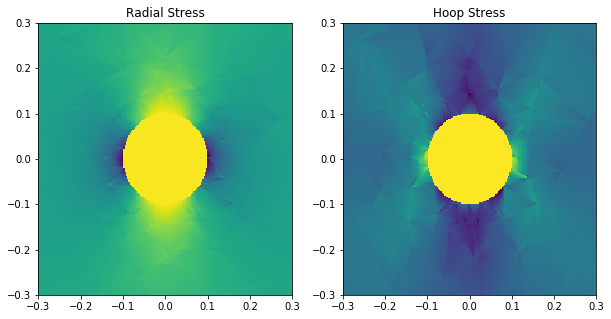

In [41]:
x = np.linspace(-0.3, 0.3, 200) 
y = np.linspace(-0.3, 0.3, 200) 
X, Y = np.meshgrid(x, y) 
Srr=[]
Stt=[]
for xx in x:
    t_Srr=[]
    t_Stt=[]
    for yy in y:
        if np.sqrt(xx*xx+yy*yy) >0.1:
            t_Srr.append(stress_function.at(xx,yy,-2.5)[0][0])
            t_Stt.append(stress_function.at(xx,yy,-2.5)[1][1])
        else:
            t_Srr.append(0)
            t_Stt.append(0)
    Srr.append(t_Srr)
    Stt.append(t_Stt)
fig, ax = plt.subplots(1,2,figsize=(10,5),gridspec_kw = {'width_ratios':[1, 1]})
#ax[0].rcParams['figure.figsize'] = [5, 5]
ax[0].set_title("Radial Stress")
ax[0].pcolormesh(X, Y, Srr,cmap = cm.viridis) 
#ax[1].rcParams['figure.figsize'] = [5, 5]
ax[1].set_title("Hoop Stress")
ax[1].pcolormesh(X, Y, Stt,cmap = cm.viridis) 

## Kirsh equations validation

We now plot the radial and the hoop stress through an horizontal going from the wellbore to the west face

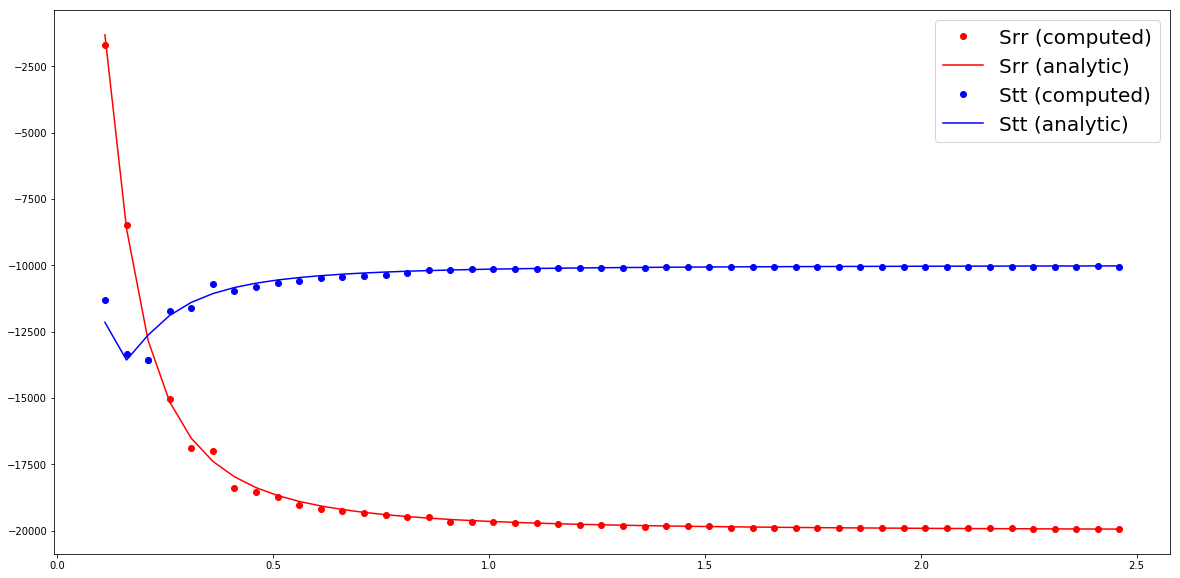

In [18]:
# We create a list of points going from the wellbore to the model boundaries
line = [(x/1000,0,-2.5) for x in range(110,2500,50)]
line_x = [x/1000 for x in range(110,2500,50)]
# We compute Srr (radial stress) and Stta (hoop stress) on this line
stress_on_line = stress_function.at(line)
Srr = [stress_on_line[x][0][0] for x in range(len(stress_on_line))]
Stt = [stress_on_line[x][1][1] for x in range(len(stress_on_line))]
#Then we compute the Kirsh solution on the line
def KirshSrr(points):
    return [-0.5*(SHMax + Shmin)*(1 -(aa*aa)/(points[x][0]**2)) - 0.5*(SHMax - Shmin)*(1-((4*aa*aa)/points[x][0]**2) + (3*aa**4)/(points[x][0]**4)) for x in range(len(points))]
def KirshStt(points):
    return [-0.5*(SHMax + Shmin)*(1 +(aa*aa)/(points[x][0]**2)) + 0.5*(SHMax - Shmin)*(1+ (3*aa**4)/(points[x][0]**4)) for x in range(len(points))]
Srr_solution = KirshSrr(line)
Stt_solution = KirshStt(line)
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(line_x,Srr,'ro')
plt.plot(line_x,Srr_solution,'r')
plt.plot(line_x,Stt,'bo')
plt.plot(line_x,Stt_solution,'b')
plt.legend(['Srr (computed)', 'Srr (analytic)', 'Stt (computed)', 'Stt (analytic)'], loc='upper right',prop={'size':20});